In [1]:
from xbbg import blp
import pdblp
import workdays
import datetime
from scipy.cluster.hierarchy import dendrogram, linkage
from matplotlib import pyplot as plt

##### Getting BDP
L = ["ES","NQ","RTY","VG","GX","Z ","PT","XP","TP","HI","XU","IH"]
T = [ i +"A Index" for i in L]
T1 = [ i +"1 Index" for i in L]
    
BDP = blp.bdp(tickers=T, flds=["name","currency","undl_spot_ticker"])
BDP = BDP.loc[T,:]

BDP1 = blp.bdp(tickers=T1, flds=["volume_avg_5d","volatility_90d"])
BDP1 = BDP1.loc[T1,:]

undl = BDP.loc[T,["undl_spot_ticker"]].loc[T,:] + " Index"

tmp=[]
for i in range(len(undl)):
    tmp += [undl.iloc[i,0]]
tmp = blp.bdp(tickers=tmp, flds="country_iso").loc[tmp,"country_iso"]
BDP["country"] = BDP["name"]
for i in range(len(T)):
    BDP["country"][i] = tmp[i]
    
    undl = BDP.loc[T,["undl_spot_ticker"]].loc[T,:] + " Index"
tmp=[]
for i in range(len(undl)):
    tmp += [undl.iloc[i,0]]
tmp = blp.bdp(tickers=tmp, flds="country_iso").loc[tmp,"country_iso"]

for i in range(len(T)):
    BDP["country"][i] = tmp[i]
BDP["volume"] = BDP1["volume_avg_5d"].values
BDP["vola"] = BDP1["volatility_90d"].values
BDP["vola"] = round(BDP["vola"],1)
BDP.insert(0, "Ticker", L)
BDP.index = list(range(len(BDP)))
BDP

,Ticker,name,currency,undl_spot_ticker,country,volume,vola
0,ES,S&P500 EMINI FUT Dec23,USD,SPX,US,1542150.2,11.3
1,NQ,NASDAQ 100 E-MINI Dec23,USD,NDX,US,597512.6,17.4
2,RTY,E-Mini Russ 2000 Dec23,USD,RTY,US,177328.0,17.3
3,VG,EURO STOXX 50 Dec23,EUR,SX5E,EU,711249.6,14.8
4,GX,DAX INDEX FUTURE Dec23,EUR,DAX,DE,60537.2,12.7
5,Z,FTSE 100 IDX FUT Dec23,GBP,UKX,GB,98833.0,12.2
6,PT,S&P/TSX 60 IX FUT Dec23,CAD,SPTSX60,CA,25680.6,12.4
7,XP,SPI 200 FUTURES Dec23,AUD,AS51,AU,110418.2,12.4
8,TP,TOPIX INDX FUTR Dec23,JPY,TPX,JP,73184.2,13.8
9,HI,HANG SENG IDX FUT Sep23,HKD,HSI,HK,110093.8,22.4


In [2]:
##### Getting BDH
con = pdblp.BCon(timeout=5000)
con.start()

d_from = workdays.workday(datetime.datetime.today(), days=-260).strftime("%Y%m%d")
d_to = workdays.workday(datetime.datetime.today(), days=-1).strftime("%Y%m%d")
df = blp.bdh(T1, ["px_last"], d_from, d_to).reset_index()

df = df[["index"]+T1]
df.columns = ["Date"]+LS

for j in range(len(LS)):    
    df[LS[j]+"_RetD"] = df[LS[j]].pct_change()
    
df.head()

,Date,ES,NQ,RTY,VG,GX,Z,PT,XP,TP,HI,XU,IH,ES_RetD,NQ_RetD,RTY_RetD,VG_RetD,GX_RetD,Z _RetD,PT_RetD,XP_RetD,TP_RetD,HI_RetD,XU_RetD,IH_RetD
0,2022-09-26,3813.12,11843.74,1723.60,3333.1,12693.27,7076.6,1124.61,6446.3,1797.9,17995.0,12808.1,17783.54,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2022-09-27,3803.77,11862.05,1729.72,3322.2,12596.99,7061.5,1122.59,6486.1,1803.8,17946.0,12958.8,17788.24,-0.002452,0.001546,0.003551,-0.003270,-0.007585,-0.002134,-0.001796,0.006174,0.003282,-0.002723,0.011766,0.000264
2,2022-09-28,3877.53,12094.40,1784.04,3327.2,12635.30,7071.6,1141.88,6440.3,1783.8,17362.0,12838.7,17612.49,0.019391,0.019588,0.031404,0.001505,0.003041,0.001430,0.017183,-0.007061,-0.011088,-0.032542,-0.009268,-0.009880
3,2022-09-29,3796.75,11751.63,1743.92,3263.3,12399.24,6934.5,1128.75,6527.0,1815.5,17281.0,12855.6,17534.79,-0.020833,-0.028341,-0.022488,-0.019205,-0.018683,-0.019387,-0.011499,0.013462,0.017771,-0.004665,0.001316,-0.004412
4,2022-09-30,3741.95,11549.90,1731.17,3310.2,12562.82,6972.3,1127.03,6446.3,1790.1,17323.0,12819.9,17822.66,-0.014433,-0.017166,-0.007311,0.014372,0.013193,0.005451,-0.001524,-0.012364,-0.013991,0.002430,-0.002777,0.016417


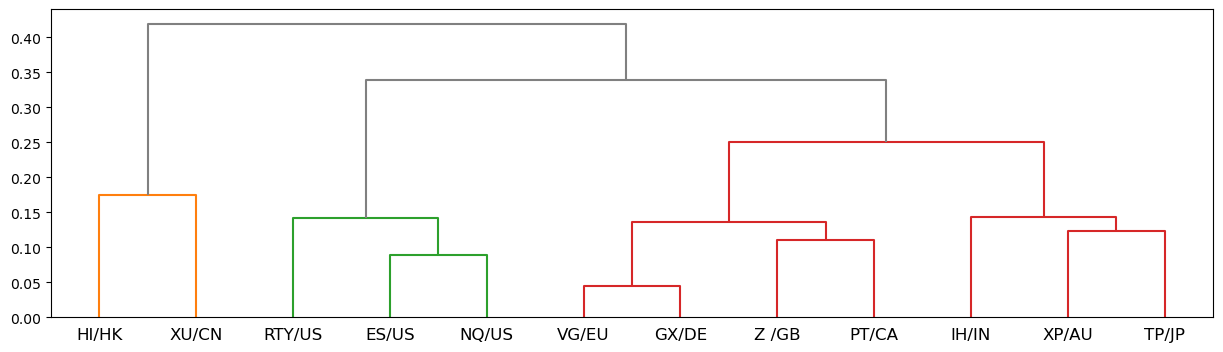

In [3]:
##### Cluster
LSC = []
for i in range(len(LS)):
    LSC += [LS[i] + "/" + BDP.loc[BDP["Ticker"]==LS[i],"country"].values[0] ]

tmp = [x + "_RetD" for x in LS]
df_Ret = df.loc[1:,tmp].reset_index(drop=True)

linkage_result = linkage(df_Ret.T, method="ward", metric="euclidean")

fig = plt.figure(figsize=(15, 4))
dn = dendrogram(linkage_result, labels=list(LSC), above_threshold_color="grey")